<a href="https://colab.research.google.com/github/UrienLin/NLPTest/blob/master/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[根據此篇文章](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d) 
所提及的 [此篇論文](https://arxiv.org/pdf/1910.10781.pdf)

將長文切割成200字的子集合，最後再根據原文及預測結果投票取情緒值

In [14]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as  pd

#Colab PATH
#PATH = '/content/drive/My Drive/20190825 Challenge/'
#Local PATH
PATH = './'

train_df = pd.read_csv(PATH + '01_Hoteltrain.csv')
test_df = pd.read_csv(PATH + '01_Hoteltest.csv')

_df = pd.concat([train_df,test_df])
_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,index,label,review
0,1,0.0,"來往虹橋機場,絕對方便,938公共汽車直接門對門,上車睡覺就可以了(一個半小時)賓館服務不專..."
1,2,1.0,來武漢出差很多次了，這次經朋友介紹，住在海怡錦江大酒店。外表看來的確一般，但住進去後，感覺還...
2,3,0.0,來長春之前，查閱了攜程的很多酒店評分，感覺這個還算不錯的，但是入住之後感覺很失望：1、房間門...
3,4,1.0,來蘇州好多次了，基本上都住在這家酒店。給我的感覺非常好，房間很乾淨，設施也很全，各種用品也很...
4,5,1.0,依海而建，地理位置絕佳，旁邊就是星海廣場。床特別大，很舒適，房間裡有咖啡包，但有一天服務生忘...


In [15]:
#檢查 LABEL 分布
train_df.label.value_counts()

1    3421
0    1579
Name: label, dtype: int64

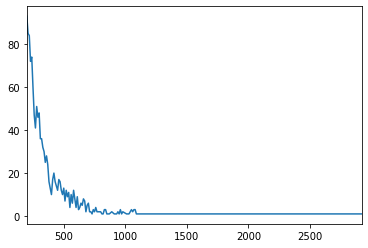

In [16]:
#檢查字串長短分佈
_df[_df.review.str.len()>200].review.str.len().map(lambda x: (int(x/10)) * 10).value_counts().sort_index().plot()

In [0]:
#切割成200 overlap 50 的子集合
def get_split(text1):
  text_total_len = 200 #default:200
  text_overlap = 50 #default:50
  text_len = text_total_len - text_overlap
  
  l_total = []
  l_parcial = []
  if len(list(text1))//text_len >0:
    n = len(list(text1))//text_len
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = list(text1)[:text_total_len]
      l_total.append("".join(l_parcial))
    else:
      l_parcial = list(text1)[w*text_len:w*text_len + text_total_len]
      l_total.append("".join(l_parcial))
  return l_total

In [0]:
#長字串切割為200,overlap = 50 
#[0~199, 150~349, 300~499, ...]
_df['review_split'] = _df.review.apply(get_split)

In [19]:
train_l = []
label_l = []
index_l = []
for idx,row in _df.iterrows():
  for rs in row['review_split']:
    train_l.append(rs)
    label_l.append(row['label'])
    index_l.append(idx)

len(train_l),len(label_l),len(index_l)

(8995, 8995, 8995)

In [20]:
#重組回來
new_df_with_idx = pd.DataFrame({'text':train_l, 'label':label_l, 'idx':index_l})
new_df = pd.DataFrame({'text':train_l, 'label':label_l ,'idx':index_l})
new_df.head()

,text,label,idx
0,"來往虹橋機場,絕對方便,938公共汽車直接門對門,上車睡覺就可以了(一個半小時)賓館服務不專...",0.0,0
1,來武漢出差很多次了，這次經朋友介紹，住在海怡錦江大酒店。外表看來的確一般，但住進去後，感覺還...,1.0,1
2,過的酒店最快的，且不收費，這是讓我最滿意的。樓下有位朋友說，衛生間太小，其實只是淋浴間不是太...,1.0,1
3,來長春之前，查閱了攜程的很多酒店評分，感覺這個還算不錯的，但是入住之後感覺很失望：1、房間門...,0.0,2
4,來蘇州好多次了，基本上都住在這家酒店。給我的感覺非常好，房間很乾淨，設施也很全，各種用品也很...,1.0,3


In [0]:
dev_0225_q1 = new_df[new_df.label!=0.5].sample(1000)
train_raw = pd.concat([new_df,dev_0225_q1]).drop_duplicates(keep=False)
test_0225_q1 = train_raw[train_raw.label == 0.5]
train_0225_q1 = pd.concat([test_0225_q1,train_raw]).drop_duplicates(keep=False)

dev_0225_q1.to_csv(PATH + 'dev_0225_q1.tsv', index=False, sep='\t', encoding='utf-8')
train_0225_q1.to_csv(PATH +'train_0225_q1.tsv', index=False, sep='\t', encoding='utf-8')
test_0225_q1.to_csv(PATH + 'test_0225_q1.tsv', index=False, sep='\t', encoding='utf-8')

In [0]:
!pip install transformers -q
!pip install pysnooper -q
import pysnooper
import torch
from transformers import BertTokenizer,BertForSequenceClassification
from IPython.display import clear_output

PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

from torch.utils.data import Dataset
    
class NewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train_0225_q1", "test_0225_q1","dev_0225_q1"]
        self.mode = mode
        self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  
    
    def __getitem__(self, idx):
        if self.mode == "test_0225_q1":
            text = self.df.iloc[idx].text
            label_tensor = None
        else:
            text, label = self.df.iloc[idx ,:2].values
            label_tensor = torch.tensor(label,dtype=torch.long)
            
        #[CLS] Sentence Token
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens
        
        len_a = len(word_pieces)
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_a ,dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
trainset = NewsDataset("train_0225_q1", tokenizer=tokenizer)
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞


In [0]:

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [35]:
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


In [0]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

In [37]:
%%time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)




model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 9  
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))
    

device: cuda:0
[epoch 1] loss: 50.196, acc: 0.910
[epoch 2] loss: 32.903, acc: 0.919
[epoch 3] loss: 25.981, acc: 0.924
[epoch 4] loss: 20.429, acc: 0.957
[epoch 5] loss: 14.230, acc: 0.952
[epoch 6] loss: 10.781, acc: 0.947
[epoch 7] loss: 7.620, acc: 0.981
[epoch 8] loss: 6.940, acc: 0.984
[epoch 9] loss: 4.528, acc: 0.985
CPU times: user 19min 49s, sys: 14min 40s, total: 34min 29s
Wall time: 34min 36s


In [38]:
devset = NewsDataset("dev_0225_q1", tokenizer=tokenizer)
devloader = DataLoader(devset, batch_size=64, 
                        collate_fn=create_mini_batch)
dev_predictions = get_predictions(model, devloader)
dev_df = pd.DataFrame({"predicted": dev_predictions.tolist()})
dev_df1 = pd.concat([devset.df, dev_df.loc[:, 'predicted']], axis=1)
dev_df1.head()

,text,label,idx,predicted
0,"酒店可能有點年限了所以設施很舊,說是三星可感覺估計也就二星到頂了,服務也很一般,關鍵是價格和...",1.0,2000,0
1,酒店離徽杭高速出口很近，很容易找到的，離黃山市中心也不遠的,1.0,2868,1
2,這是我住過酒店最糟糕的一次，首先是入住房間弄錯了，和別人的房間重複了，接著是晚上睡覺半夜2點...,0.0,3303,0
3,拿房時沒大床房了，給我們免費升成套房，這點還蠻滿意的。酒店大致不錯，有國內五星水準。比國際品...,1.0,1800,1
4,總體服務不錯，高級房裝修還可以，隔音太差，空調聲音吵。但總體尚可,1.0,4713,1


In [39]:
dev_df1[dev_df1.label != dev_df1.predicted].head()

,text,label,idx,predicted
0,"酒店可能有點年限了所以設施很舊,說是三星可感覺估計也就二星到頂了,服務也很一般,關鍵是價格和...",1.0,2000,0
15,，我的朋友沒去成，我在下午4點半取消了一個房間和2個早餐，但是結帳時卻收我2份早餐錢。我已經...,0.0,1305,1
23,設施不是一般的差，就是一個招待所。我的毛巾掛在衛生間，等要用的時候，竟然發現上面爬了臭蟲。只...,0.0,3148,1
42,酒店員工的禮儀意識十分差！！堂堂一家准五星的前臺工作人員，當著顧客的面大摳鼻屎，真是讓人十分...,1.0,2573,0
44,還是房價貴了點，如果房價在200就可以了。,0.0,4854,1


In [0]:
#torch.save(model, PATH + 'model02251557.pt')  # 保存整个网络
#torch.save(model.state_dict(), PATH + 'model02251557.pt')   # 只保存网络中的参数 (速度快, 占内存少)

In [40]:
testset = NewsDataset("test_0225_q1", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=64, 
                       collate_fn=create_mini_batch)
predictions = get_predictions(model, testloader)
df = pd.DataFrame({"predicted": predictions.tolist()})
df1 = pd.concat([testset.df, df.loc[:, 'predicted']], axis=1)
df1.head()

,text,label,idx,predicted
0,"""此期間預訂，入住首日酒店贈送每間房10元洗衣券一張，通過攜程預訂，入住首日每房還可獲贈歡迎...",0.5,0,1
1,&#35828;&#23454;&#35805;，&#23545;景&#21306;酒店的硬...,0.5,1,1
2,38169;的（可能是期望低的&#32536;故吧）。酒店硬體普通，但&#29615;境超好...,0.5,1,1
3,推。唯一提出表&#25196;的是酒店&#33829;&#38144;部&#38376;的相...,0.5,1,1
4,，&#35828;是全部&#39044;&#35746;光了，我靠！！！怎麼能不&#3247...,0.5,1,1


In [41]:
df1.predicted.value_counts()

1    2345
0    1042
Name: predicted, dtype: int64

In [42]:
df1.groupby(['idx']).agg({'predicted':'mean'}).reset_index().predicted.value_counts().sort_index()

0.000000     713
0.125000       1
0.142857       3
0.166667       2
0.200000       1
0.210526       1
0.230769       1
0.250000       2
0.285714       1
0.333333      16
0.400000       2
0.428571       1
0.444444       1
0.500000      36
0.600000       3
0.666667      15
0.750000       8
0.800000       3
0.833333       1
0.857143       1
1.000000    1953
Name: predicted, dtype: int64

In [0]:
ans = df1.groupby(['idx']).agg({'predicted':'mean'}).reset_index()
ans

,idx,predicted
0,0,0.000000
1,1,0.571429
2,2,1.000000
3,3,0.000000
4,4,1.000000
...,...,...
2760,2760,1.000000
2761,2761,0.000000
2762,2762,1.000000
2763,2763,1.000000


In [0]:
ans.predicted = ans.predicted.apply(lambda x: 1 if x>0.4 else 0 )
ans.predicted.value_counts().sort_index()

In [0]:
#ans.to_csv('/content/drive/My Drive/predicted0225final.csv',index=False)

In [0]:
ans

,idx,predicted
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
2760,2760,1
2761,2761,0
2762,2762,1
2763,2763,1
